# Data Science 1 - Signal analysis

## Lesson 1 - Polynomial interpolation

&copy; 2021, dr.ir. Dave R.M. Langers (LADR, ZP11/H1.90, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl))

<img src="https://bioinf.nl/~davelangers/dave.png" width="10%" height="10%" alt="Dave Langers" /> 

<small>**Note:** step forward using `SPACE` or backward using `SHIFT`+`SPACE`, or use the arrows in the bottom right to navigate; run code cells using `CTRL`+`ENTER`.</small>

In [1]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython.display import display
from lesson1 import figure

### Main material

*Numerical methods in engineering with python 3*, **chapter 3.1 & 3.2**

<img src="https://images-na.ssl-images-amazon.com/images/I/51963RBvJDL._SX348_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Numerical methods in engineering with python 3" />

### <a id="/1">Lesson 1 - Polynomial interpolation</a>

* <u>Part 1A</u><br />*Introduction*

* <span style="color:#336699"><a href="#/8">Part 1B</a><br />Lagrange interpolation</span>

* <span style="color:#336699"><a href="#/12">Part 1C</a><br />Vandermonde matrix interpolation</span>

* <span style="color:#336699"><a href="#/16">Part 1D</a><br />Rational interpolation</span>

### Data Analysis versus Signal Analysis

[Data analysis](https://en.wikipedia.org/wiki/Data_analysis)
  
* operates on numerous discrete instances (cases, in rows)

* typically comprises multiple attributes (variables, in columns)

* measurements are of various types (nominal, numeric, etc.)

The order of the instances and attributes do not matter; i.e., rows or columns can be reordered without loss of information.

For instance, several diagnostics are measured for numerous patients, or expression profiles are determined for multiple genes.

In [2]:
figure(1)

,Sex,Age,Province,BMI,Infected
ID,,,,,
1,♂,27,Fryslân,29.2,False
2,♀,21,Drenthe,24.9,False
3,♀,46,Drenthe,20.7,False
4,♂,37,Fryslân,25.4,False
5,♀,21,Groningen,25.1,False
6,♀,36,Drenthe,26.3,False
7,♂,37,Groningen,22.8,False


Figure 1: SARS-CoV-2 patient characteristics


[Signal analysis](https://en.wikipedia.org/wiki/Digital_signal_processing)

* quantity of interest varies like a function over a continuous domain

* typically comprises one [signal](https://en.wikipedia.org/wiki/Signal) at a time

* measurements are of a numeric type

The order of the data values *does* matter; i.e., information is lost when the data is shuffled.

<small>**Note:** Most signals describe the value of some quantity over *time*. However, other continuous domains are possible (e.g. a spatial dimension, frequency spectrum), and multidimensional signals also exist (e.g. images, movies).</small>

For instance, for an electrocardiogram an electric voltage is measured over time, or when studying population dynamics count data may be collected spanning multiple years.

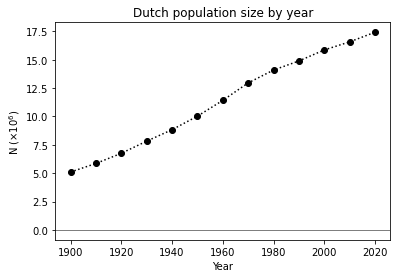

Figure 2: Dutch population size by year


In [3]:
figure(2)

### Discretization

When an original [analog signal](https://en.wikipedia.org/wiki/Analog_signal) $y(x)$ is [discretized](https://en.wikipedia.org/wiki/Discretization) into a [digital signal](https://en.wikipedia.org/wiki/Digital_signal) $(x_i, y_i)$, some information is lost and a number of characteristics change:

* Signals are [truncated](https://en.wikipedia.org/wiki/Data_truncation) to a limited range.<br /><br />
  For *online* instead of *offline* signal processing, signals are analyzed "live" as they come in.

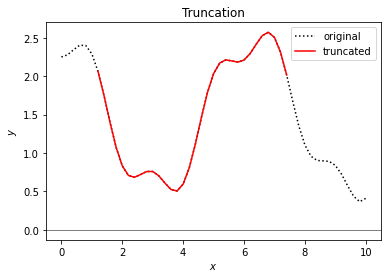

Figure 3: Truncation


In [4]:
figure(3)

* Signals are [sampled](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) at discrete points in their domain.<br /><br />
  Samples may be regularly or irregularly spaced; errors include jitter when the signal is sampled at inaccurate times, and aperture errors when the signal is averaged over a finite window.

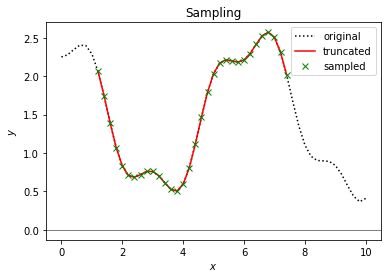

Figure 4: Sampling


In [5]:
figure(4)

* Signals are [quantized](https://en.wikipedia.org/wiki/Quantization_(signal_processing)) with finite precision.<br /><br />
  Digital signals include quantization error due to round-off, and may show clipping if the representable range is exceeded.

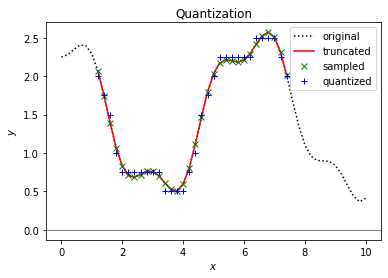

Figure 5: Quantization


In [6]:
figure(5)

### Polynomial interpolation

When only a limited set of discrete values $(x_i, y_i)$ are available, the original continuous signal $y(x)$ may be approximated at intermediate values $x$ by [interpolation](https://en.wikipedia.org/wiki/Interpolation).

<small>**Note:** If the value of $x$ lies outside of the truncated interval, then this is called [extrapolation](https://en.wikipedia.org/wiki/Extrapolation); extrapolation typically involves larger errors than interpolation.</small>

Because the original signal is not known, some assumptions need to be made regarding its shape. Common functions that are often used as the *interpolant* are the following:

* [Polynomial functions](https://en.wikipedia.org/wiki/Polynomial), for short signals

* [Piecewise functions](https://en.wikipedia.org/wiki/Piecewise), for long signals

* [Trigonometric functions](https://en.wikipedia.org/wiki/Trigonometric_functions), for quasi-periodic signals

A polynomial of *degree* $p$ is a function of the form

$$
y(x) = a_p \cdot x^p + a_{p-1} \cdot x^{p-1} + \ldots + a_2 \cdot x^2 + a_1 \cdot x + a_0
$$

There are $n=p+1$ coefficients $a_p$ to $a_0$. These can always be chosen in such a way that $y(x_i)$ *exactly* equals $y_i$ for $n$ distinct data points $(x_i, y_i)$.

Therefore, if we are provided with $n$ data points with distinct $x_i$, we can always find an $(n-1)$<sup>th</sup> degree polynomial that exactly reproduces these data and that approximates the signal at other values for $x$.

### Example

Consider the following data regarding the monthly number of confirmed Covid cases in the municipality of Groningen (from: [Coronavirus Dashboard](https://coronadashboard.government.nl/landelijk/positief-geteste-mensen)).

| Year | Month | Cases |   | Year | Month | Cases |
| ---- | ----- | ----- | - | ---- | ----- | ----- |
| 2020 | -     | -     |   | 2021 | Jan   | 1399  |
|      | Mar   | 92    |   |      | Mar   | 1590  |
|      | May   | 7     |   |      | May   | 1261  |
|      | Jul   | 16    |   |      | Jul   | 5690  |
|      | Sep   | 885   |   |      | Sep   | 670   |
|      | Nov   | 849   |   |      | Nov   | 3271  |

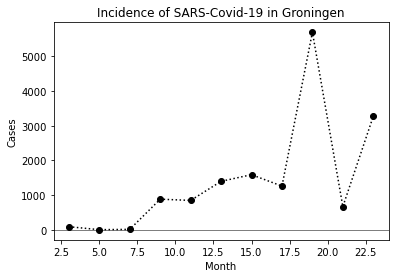

In [7]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.show()

Although the numbers for odd months are listed, the even months are missing in these data. However, using polynomial interpolation we may estimate values for those as well.

The `scipy.interpolate` module provides the `lagrange()` function that implements polynomial interpolation. Required arguments are vectors $\boldsymbol{x}$ and $\boldsymbol{y}$.

In [8]:
from scipy.interpolate import lagrange
help(lagrange)

Help on function lagrange in module scipy.interpolate.interpolate:

lagrange(x, w)
    Return a Lagrange interpolating polynomial.
    
    Given two 1-D arrays `x` and `w,` returns the Lagrange interpolating
    polynomial through the points ``(x, w)``.
    
    be able to use more than about 20 points even if they are chosen optimally.
    
    Parameters
    ----------
    x : array_like
        `x` represents the x-coordinates of a set of datapoints.
    w : array_like
        `w` represents the y-coordinates of a set of datapoints, i.e., f(`x`).
    
    Returns
    -------
    lagrange : `numpy.poly1d` instance
        The Lagrange interpolating polynomial.
    
    Examples
    --------
    Interpolate :math:`f(x) = x^3` by 3 points.
    
    >>> from scipy.interpolate import lagrange
    >>> x = np.array([0, 1, 2])
    >>> y = x**3
    >>> poly = lagrange(x, y)
    
    Since there are only 3 points, Lagrange polynomial has degree 2. Explicitly,
    it is given by
    
    .. m

The function returns a `poly1d` object (a polynomial in one variable) that can be printed in readable form. Since there are 11 data points, the polynomial is of degree 10.

In [19]:
polynomial = lagrange(months, cases)
print(polynomial)

           10            9          8         7         6        5
4.184e-05 x  - 0.004998 x + 0.2592 x - 7.667 x + 142.8 x - 1743 x
              4            3             2
 + 1.408e+04 x - 7.41e+04 x + 2.424e+05 x - 4.443e+05 x + 3.461e+05


The $n$ coefficients are accessible through an array $\boldsymbol{a} = \left[ a_p, \ldots, a_1, a_0 \right]$ as the property `coefficients` (or shorter as `c`, `coef`, or `coeffs`).

In [20]:
polynomial.coefficients

array([ 4.18432596e-05, -4.99788045e-03,  2.59232540e-01, -7.66747808e+00,
        1.42774656e+02, -1.74311292e+03,  1.40827621e+04, -7.41009487e+04,
        2.42383880e+05, -4.44264266e+05,  3.46109323e+05])

In [21]:
polynomial.c

array([ 4.18432596e-05, -4.99788045e-03,  2.59232540e-01, -7.66747808e+00,
        1.42774656e+02, -1.74311292e+03,  1.40827621e+04, -7.41009487e+04,
        2.42383880e+05, -4.44264266e+05,  3.46109323e+05])

The resulting object is callable and behaves like a function. It will return the value of the polynomial for certain $x$.

In [22]:
polynomial(0.0)

346109.32349014306

When we interpolate the number of cases for intermediate months in 2020 and 2021, we observe that the measured data are exactly reproduced by the interpolant.

However, the function oscillates and overshoots near the edges of the interval for which data are available. This disadvantage of polynomial interpolation, known as [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon), occurs most pronouncedly for high-degree polynomials.

<small>**Note:** We will study methods that avoid Runge's phenomenon later.</small>

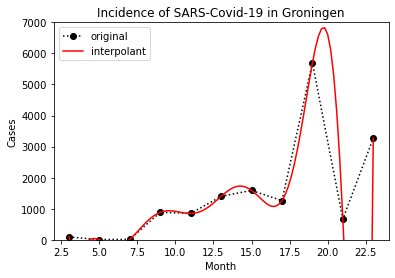

In [23]:
x = np.linspace(3.0, 23.0, 101)
y = polynomial(x)

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='interpolant')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

### Implementations in `scipy` and `pandas`

Apart from `lagrange()`, the `scipy.interpolate` module contains two other classes that perform polynomial interpolation. These also require vectors $\boldsymbol{x}$ and $\boldsymbol{y}$, but do not allow the polynomial to be printed or coefficients to be extracted. However, they provide other functionality.

* `BarycentricInterpolator()` allows $(x_i, y_i)$ data to be changed or appended dynamically.

* `KroghInterpolator()` allows derivatives to be specified in addition to function values.

Both return a callable object. For our purposes, the following calls are essentially equivalent:

* `polynomial = lagrange(xi, yi)`

* `polynomial = BarycentricInterpolator(xi, yi)`

* `polynomial = KroghInterpolator(xi, yi)`

Both classes are accompanied by convenience functions `barycentric_interpolate()` and `krogh_interpolate()` that determine and apply the polynomial in one function call. They require three arguments: `xi` and `yi` (the data to interpolate from) and `x` (the $x$-values to determine $y$-values for).

The lagrange function does not have such a convenience function, but this can easily be defined as follows.

In [24]:
def lagrange_interpolate(xi, yi, x):
    polynomial = lagrange(xi, yi)
    return polynomial(x)

In `pandas`, the `Series` as well as the `DataFrame` object exposes an `interpolate()` method with arguments `method='barycentric'` or `method='krogh'` that can impute missing values from the available other data by means of polynomial interpolation, using the index as the $x$-variable.

In [25]:
quadratic = pd.DataFrame({
    '$y_i$': [np.nan, 1.0, np.nan, np.nan, 16.0, 25.0, 36.0, np.nan]
}).rename_axis('$x_i$')
for method in ('barycentric', 'krogh'):
    column = '$y_{i,\text{' + method + '}}$'
    quadratic[column] = quadratic['$y_i$'].interpolate(method=method, limit_direction='both')

quadratic

,$y_i$,"$y_{i,\text{barycentric}}$","$y_{i,\text{krogh}}$"
$x_i$,,,
0,NaN,1.332268e-14,0.0
1,1.0,1.000000e+00,1.0
2,NaN,4.000000e+00,4.0
3,NaN,9.000000e+00,9.0
4,16.0,1.600000e+01,16.0
5,25.0,2.500000e+01,25.0
6,36.0,3.600000e+01,36.0
7,NaN,4.900000e+01,49.0


<small>**Note:** the argument `limit_direction='both'` allows extrapolation on both sides.</small>

### Exercise 1

The interpolated number of SARS-Covid-19 cases in the previous example contained some negative values, which is unrealistic. To avoid this, we may model the logarithm of the number of cases $\log(y)$ as a polynomial function of $x$.

Plot the resulting interpolation curve from March '20 to November '21. Has the result improved in your opinion?

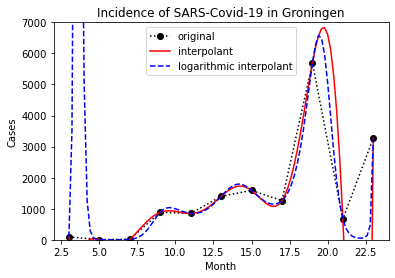

In [32]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])


x = np.linspace(3.0, 23.0, 101)
y = polynomial(x)

f = lagrange(months, np.log(cases))
y_log = f(x)


plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='interpolant')
plt.plot(x, np.exp(y_log), '--b', label='logarithmic interpolant')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

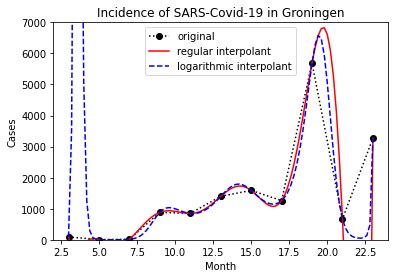

### Exercise 2

Given the following data regarding the population size of the Netherlands (from: [Wikipedia](https://en.wikipedia.org/wiki/Demography_of_the_Netherlands#/Births_and_deaths)), extrapolate the current population size.

| Year | Size       |   | Year | Size       |   | Year | Size       |
| ---- | ---------- | - | ---- | ---------- | - | ---- | ---------- |
| 1900 |  5,104,000 |   | 1950 | 10,026,773 |   | 2000 | 15,863,950 |
| 1910 |  5,858,000 |   | 1960 | 11,417,254 |   | 2010 | 16,574,989 |
| 1920 |  6,754,000 |   | 1970 | 12,957,621 |   | 2020 | 17,424,978 |
| 1930 |  7,825,000 |   | 1980 | 14,091,014 |   |      |            |
| 1940 |  8,834,000 |   | 1990 | 14,892,574 |   |      |            |

Try fitting the data using a polynomial as a function of the 4-digit year (i.e. 1900 to 2020), or as a function of the 2-digit year (i.e. 1900 is 0, 1910 is 10, ..., 2010 is 110, 2020 is 120, etc.). Also try fitting a polynomial through all data, or only through the data from 2000 onwards. Do you find reliable answers? Explain your observations.

In [35]:
data = {'Year': [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020],
       'Size': [5104000, 5858000, 6754000, 7825000, 8834000, 10026773, 11417254, 12957621, 14091014, 14892574, 15863950, 16574989, 17424978]}

df = pd.DataFrame(data=data)

In [52]:
from scipy.interpolate import interp1d

In [57]:
xi, yi = data['Year'], data['Size']

f = interp1d(xi, yi, kind='linear', fill_value='extrapolate')

x = 2021
y = f(x)

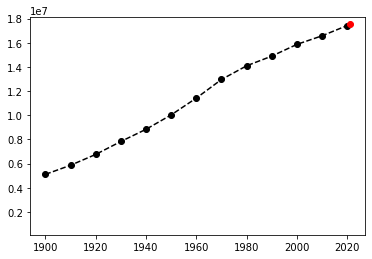

In [58]:
plt.plot(xi, yi, '--o', color='black')
plt.plot(x, y, 'o', color='red')
plt.ylim([0.01e7, 1.81e7])
plt.show()

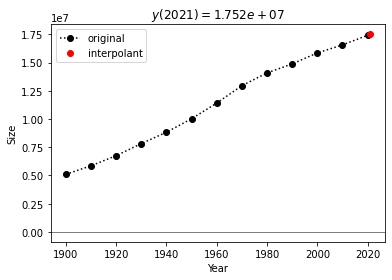

### Exercise 3

Below you find the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

Fit a polynomial through these data, and verify that the obtained model function predicts the correct temperatures for each month. Is this a good method to estimate the temperature halfway between January and February though? Or halfway between June and July?

In [59]:
data = {'Month': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'Temp': [2.5, 2.9, 5.5, 8.9, 12.4, 15.1, 17.5, 17.2, 14.2, 10.2, 6.1, 3.3]}

df = pd.DataFrame(data=data)

In [65]:
xi, yi = data['Month'], data['Temp']

f = lagrange(xi, yi)

x = np.linspace(0, 11, 501)
y = f(x)

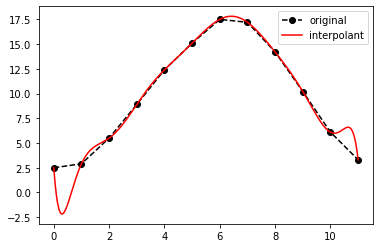

In [66]:
plt.plot(xi, yi, '--o', color='black', label='original')
plt.plot(x, y, '-r', label='interpolant')

plt.legend(loc='best')
plt.show()

,Month,Temperature,Interpolation
0,January,2.5,2.5
1,February,2.9,2.9
2,March,5.5,5.5
3,April,8.9,8.9
4,May,12.4,12.4
5,June,15.1,15.1
6,July,17.5,17.5
7,August,17.2,17.2
8,September,14.2,14.2
9,October,10.2,10.2


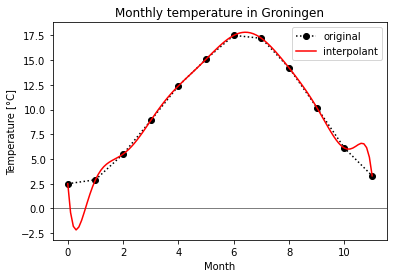

### Exercise 4

A useful application of interpolation is *resampling*. The following code irregularly samples a special mathematical function, the [Bessel function](https://en.wikipedia.org/wiki/Bessel_function) $J_0(x)$, at $n = 10$ sparsely distributed random points.

```python
from scipy.special import jv
n = 10
xi = np.linspace(-5.0, 5.0, n) + np.random.randn(n)
yi = jv(0, xi)
```

Using the `xi` and `yi` arrays, apply polynomial interpolation to estimate this function at a dense regular grid of equidistant values $x \in \left\{ -5.0, -4.8, -4.6, \ldots, +4.8, +5.0 \right\}$. Plot the resulting data together with the Bessel function `jv(0, x)` itself. Comment on the quality of the fit.

In [86]:
from scipy.special import jv
n = 10
xi = np.linspace(-5.0, 5.0, n) + np.random.randn(n)
yi = jv(0, xi)


f = lagrange(xi, yi)

x = np.linspace(-5.0, 5.0, 50)
y_jv = jv(0, x)
y = f(x)

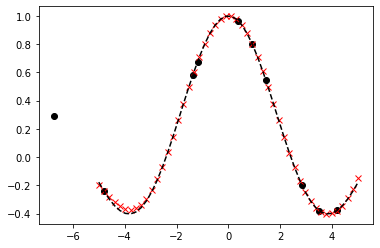

In [89]:
plt.plot(xi, yi, 'o', color='black')
plt.plot(x, y, 'x', color='red')
plt.plot(x, y_jv, '--', color='black')

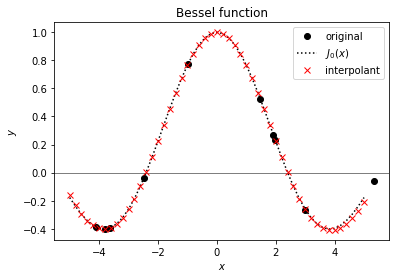

### Exercise 5

The [square pyramidal numbers](https://en.wikipedia.org/wiki/Square_pyramidal_number) $P(n)$ can be defined as the sum of consecutive squares.

$$
P(n) = \sum_{k=1}^n k^2 = 1 + 4 + 9 + \ldots + n^2
$$

This leads to the following [sequence](http://oeis.org/A000330).

| $n$    | 0   | 1   | 2   | 3   | 4   | 5   | 6   | ... |
| ------ | --- | --- | --- | --- | --- | --- | --- | --- |
| $P(n)$ | 0   | 1   | 5   | 14  | 30  | 55  | 91  | ... |

However, this definition only works for integer values of $n$.

Fit a polynomial to this sequence and interpolate the value for $P(\frac{1}{2})$. How well does your answer agree with the theoretical value of $P(\frac{1}{2}) = \frac{1}{4} = 0.250$?

In [94]:
def P(n):
    t = 0
    for k in range(n+1):
        t += k**2
        
    return t

In [106]:
xi = list(range(0, 5, 1))
yi = [P(n) for n in range(0, 5, 1)]

f = lagrange(xi, yi)

_x = np.linspace(-0.5, 4.5, 101)
_y = f(_x)

x = 1/2
y = f(x)

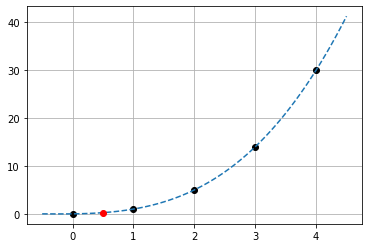

In [109]:
plt.plot(xi, yi, 'o', color='black')
plt.plot(_x, _y, '--')
plt.plot(x, y, 'or')

plt.grid(True)

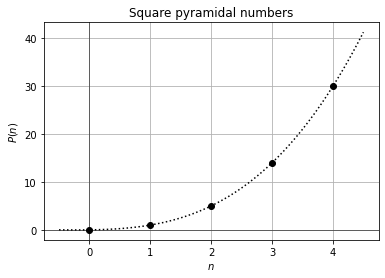

Figure 6: Square pyramidal numbers


In [20]:
figure(6)

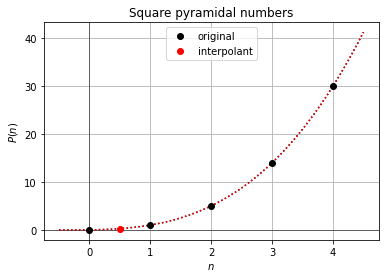

### <a id="/8">Lesson 1 - Polynomial interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 1A</a><br />Introduction</span>

* <u>Part 1B</u><br />*Lagrange interpolation*

* <span style="color:#336699"><a href="#/12">Part 1C</a><br />Vandermonde matrix interpolation</span>

* <span style="color:#336699"><a href="#/16">Part 1D</a><br />Rational interpolation</span>

### Lagrange interpolation

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Lagrange_portrait.jpg" width="10%" height="10%" alt="Joseph-Louis Lagrange" />

Lagrange devised a method to derive the interpolating polynomial. It operates by defining a *cardinal* function $l_i(x)$ for each data point $(x_i, y_i)$ with the following special properties:

* $l_i(x) = 1$ when $x = x_i$

* $l_i(x) = 0$ when $x = x_j$ with $j \ne i$

The plot shows the cardinal functions for $n=4$ data points with $\boldsymbol{x} = \left[ 1, 2, 3, 5 \right]$.

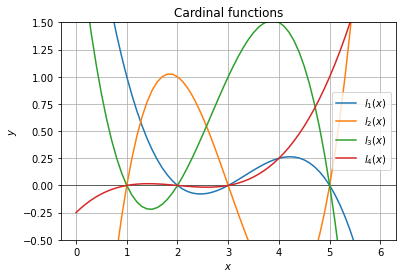

Figure 7: Cardinal functions


In [22]:
figure(7)

A polynomial with zeros at all $x_j$ with $j \ne i$ can be constructed by multiplying terms of the form $(x-x_j)$, ensuring that for each $x_j$ there will be a zero term in the product. Thus we find $l'_i(x) = \prod_{j \ne i} (x-x_j)$.

However, $l'_i(x)$ generally does not equal 1 when $x=x_i$. This is remedied by dividing the polynomial by its value at $x_i$, thus finding $l_i(x) = \frac{l'_i(x)}{l'_i(x_i)}$.

This results in a final expression

$$
\begin{aligned}
l_i(x) &= \frac{x-x_1}{x_i-x_1} \cdot \frac{x-x_2}{x_i-x_2} \cdots \frac{x-x_{i-1}}{x_i-x_{i-1}} \cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdots \frac{x-x_n}{x_i-x_n}
\\
&= \prod_{j \neq i} \frac{x-x_j}{x_i-x_j}
\end{aligned}
$$

By multiplying these cardinal polynomials with the corresponding $y_i$, and summing over all $i$, we find the interpolating polynomial. Verify that we can express $y(x)$ as

$$
y(x) = \sum_{i=1}^{n} y_i \cdot l_i(x)
$$

where $i$ runs over the $n$ data samples.

### Example

We wish to find the equation of the quadratic polynomial that passes through the points $(0,1)$, $(1,2)$, and $(2,-1)$.

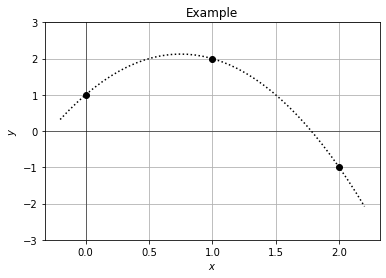

Figure 8: Example


In [23]:
figure(8)

First determine the cardinal functions:

* $l_1(x) = \frac{(x-1)(x-2)}{(0-1)(0-2)} = \frac{x^2 - 3x + 2}{2} = \frac{1}{2}x^2 - \frac{3}{2}x + 1$

* $l_2(x) = \frac{(x-0)(x-2)}{(1-0)(1-2)} = \frac{x^2 - 2x}{-1} = -x^2 + 2x$

* $l_3(x) = \frac{(x-0)(x-1)}{(2-0)(2-1)} = \frac{x^2 - x}{2} = \frac{1}{2}x^2 - \frac{1}{2}x$

Now, the desired polynomial is $y(x) = y_1 \cdot l_1(x) + y_2 \cdot l_2(x) + y_3 \cdot l_3(x)$. This equals $1 \cdot (\frac{1}{2}x^2 - \frac{3}{2}x + 1) + 2 \cdot (-x^2 + 2x) - 1 \cdot (\frac{1}{2}x^2 - \frac{1}{2}x)$, which simplifies to

$$
y(x) = -2x^2 + 3x + 1
$$

Check that all three original points satisfy this equation.

If we want to compute $y(x)$ for some particular value of $x$, we do not need to determine the interpolating polynomial's equation explicitly. We can enter the value for $x$ already when determining the cardinal functions. For example, to determine $y(-1)$:

* $l_1(-1) = \frac{(-1-1)(-1-2)}{(0-1)(0-2)} = \frac{6}{2} = 3$

* $l_2(-1) = \frac{(-1-0)(-1-2)}{(1-0)(1-2)} = \frac{3}{-1} = -3$

* $l_3(-1) = \frac{(-1-0)(-1-1)}{(2-0)(2-1)} = \frac{2}{2} = 1$

We then immediately arrive at $y(-1) = 1 \cdot 3 + 2 \cdot (-3) - 1 \cdot 1 = -4$.

### Exercise 6

What is the formula for the cubic polynomial that passes through the points $(-1, -2)$, $(0, 0)$, $(1, 2)$, and $(2, 2)$?

First determine the cardinal functions:

* $l_1(x) = \frac{(x-0)(x-1)(x-2)}{(-1-0)(-1-1)(-1-2} = \frac{x(x-1)(x-2)}{-6} = -\frac{1}{6}x^3 + \frac{1}{3}x^2 - \frac{1}{3}x$

* $l_2(x) = \frac{(x-(-1))(x-1)(x-2)}{(0-(-1))(0-1)(0-2)} = \frac{(x+1)(x-1)(x-2)}{(1)(-1)(-2)} = \frac{(x^2-1)(x-2)}{2} = \frac{1}{2}x^3-x^2-\frac{1}{2}x+1$
* $l_3(x) = \frac{(x-(-1))(x-0)(x-2)}{(1-(-1))(1-0)(1-2)} = \frac{(x+1)(x-0)(x-2)}{(2)(1)(-1)} = \frac{(x^2 + x)(x-2)}{-2} = \frac{x^3-2x^2-x+2}{-2} = -\frac{1}{2}x^3 + \frac{1}{2}x^2 + x$
* $l_4(x) = \frac{(x-(-1))(x-0)(x-1)}{(2-(-1))(2-0)(2-1)} = \frac{(x+1)(x-0)(x+1)}{(3)(2)(-1)} = \frac{(x^2 + x)(x-1)}{6} = \frac{x^3-x}{6} = \frac{1}{6}x^3 - \frac{1}{6}x$



Now, the desired polynomial is $y(x) = y_1 \cdot l_1(x) + y_2 \cdot l_2(x) + y_3 \cdot l_3(x) + y_4 \cdot l_4(x)$. This equals $-2 \cdot (-\frac{1}{6}x^3 + \frac{1}{3}x^2 - \frac{1}{3}x) + 0 \cdot (\frac{1}{2}x^3-x^2-\frac{1}{2}x+1) +2 \cdot (-\frac{1}{2}x^3 + \frac{1}{2}x^2 + x) + 2 \cdot(\frac{1}{6}x^3 - \frac{1}{6}x)$, which simplifies to

$$
y(x) = -\frac{1}{3}x^3 + \frac{1}{3}x^2 + \frac{4}{3}x
$$

**INCORRECT** SOMEHOW I MADE A MISTAKE FOR $x^2$ and $x^1$

In [10]:
xi = np.array([-1, 0, 1, 2])
yi = np.array([-2, 0, 2, 2])

f = lagrange(xi, yi)
f.coef

array([-0.33333333,  0.        ,  2.33333333,  0.        ])

### Exercise 7

Complete the below skeleton function `lagrange_interpolate()` that interpolates between a number of given data points that are specified in arrays `xi` and `yi` using Lagrange's method, and calculates the $y$-values that correspond with all the $x$-values that are requested.

<small>**Note:** Write your own code that implements the described formulas; do *not* simply wrap the `lagrange()` function from `scipy`!</small>

```python
def lagrange_interpolate(xi, yi, x):
    """y = lagrange_interpolate(xi, yi, x).
    Lagrange's interpolation method that fits a
    polynomial of degree n-1 through n data points
    {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [53]:
def lagrange_interpolate(xi, yi, x):
    """y = lagrange_interpolate(xi, yi, x).
    Lagrange's interpolation method that fits a
    polynomial of degree n-1 through n data points
    {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
        
    # make sure xi and yi are float64
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    y = 0
    for i in range(xi.size):
        cardinals = 1

        for j in range(xi.size):
            if j != i:
                cardinals *= (x - xi[j])/(xi[i] - xi[j])

        y += yi[i] * cardinals
        
    return y

In [51]:
xi = np.array([0, 1, 2])
yi = np.array([1, 2, -1])

In [52]:
lagrange_interpolate(xi, yi, -1)

-4.0

### Exercise 8

Compare the output of your own function `lagrange_interpolate()` to that of `scipy`'s `lagrange()` function for the data from exercise 1.

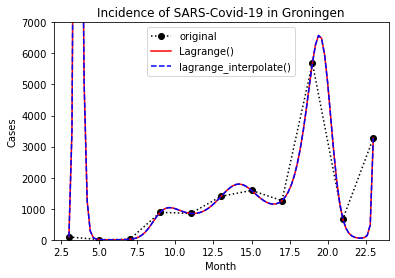

In [58]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])


x = np.linspace(3.0, 23.0, 101)

f = lagrange(months, np.log(cases))
y_log = f(x)

y_ = lagrange_interpolate(months, np.log(cases), x)


plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, np.exp(y_log), '-r', label='Lagrange()')
plt.plot(x, np.exp(y_), '--b', label='lagrange_interpolate()')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

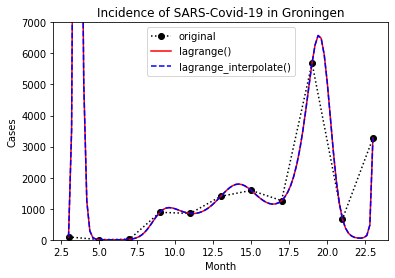

### Exercise 9

The [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number) $F(n)$ can be defined using the recurrence relation

$$
F(n+1) = F(n) + F(n-1)
$$

and starting values $F(0)=0$ and $F(1)=1$.

This leads to the following [sequence](http://oeis.org/A000045).

| $n$    | 0   | 1   | 2   | 3   | 4   | 5   | 6   | ... |
| ------ | --- | --- | --- | --- | --- | --- | --- | --- |
| $F(n)$ | 0   | 1   | 1   | 2   | 3   | 5   | 8   | ... |

However, this definition only works for integer values of $n$.

Fit a polynomial to this sequence and interpolate the value for $F(\frac{1}{2})$. How well does your answer agree with the theoretical value of $F(\frac{1}{2}) = \sqrt{\frac{1+\sqrt{5}}{10}} \approx 0.569$?

In [59]:
def Fibonacci(n):
   
    # Check if input is 0 then it will
    # print incorrect input
    if n < 0:
        print("Incorrect input")
 
    # Check if n is 0
    # then it will return 0
    elif n == 0:
        return 0
 
    # Check if n is 1,2
    # it will return 1
    elif n == 1 or n == 2:
        return 1
 
    else:
        return Fibonacci(n-1) + Fibonacci(n-2)

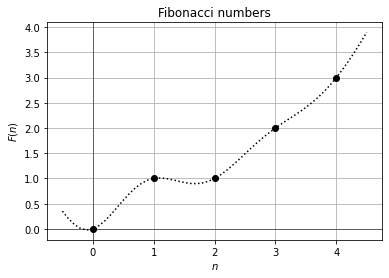

Figure 9: Fibonacci numbers


In [26]:
figure(9)

In [75]:
phi = 0.5 + 0.5 * np.sqrt(5.0)

xi = [0, 1, 2, 3, 4]
yi = [Fibonacci(i) for i in range(5)]

x = np.linspace(-0.5, 4.5, 101)
phi_y = (phi ** x - np.cos(np.pi * x) * (1.0 / phi) ** x) / np.sqrt(5.0)


f = lagrange(xi, yi)
y = f(x)
x_half = 1/2
y_half = f(x_half)

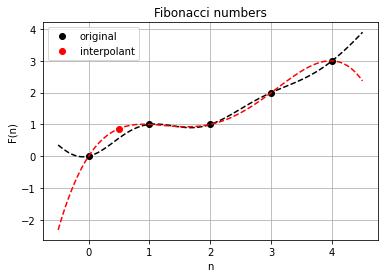

In [80]:
plt.plot(xi, yi, 'o', color='black', label='original')
plt.plot(x, phi_y, '--', color='black')
plt.plot(x, y, '--' , color='red')
plt.plot(x_half, y_half, 'o', color='red', label='interpolant')
plt.grid(True)

plt.title('Fibonacci numbers')
plt.ylabel('F(n)')
plt.xlabel('n')
plt.legend()
plt.show()

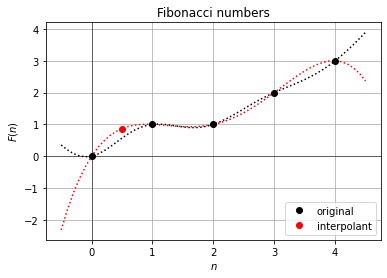

### <a id="/12">Lesson 1 - Polynomial interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 1A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/8">Part 1B</a><br />Lagrange interpolation</span>

* <u>Part 1C</u><br />*Vandermonde matrix interpolation*

* <span style="color:#336699"><a href="#/16">Part 1D</a><br />Rational interpolation</span>

### Vandermonde matrix interpolation

If the $n$ data points $(x_i, y_i)$ all lie on the graph of the $p$<sup>th</sup> degree polynomial $y(x)=a_p x^p+\ldots+a_1 x+a_0$, then we obtain a system of $n$ equations (one for each data point) in $n$ unknowns ($a_p$ to $a_0$).

$$
\begin{aligned}
y_1 &= a_p x_1^p+\ldots+a_1 x_1+a_0
\\
y_2 &= a_p x_2^p+\ldots+a_1 x_2+a_0
\\
&\vdots
\\
y_n &= a_p x_n^p+\ldots+a_1 x_n+a_0
\end{aligned}
$$

This can be written in matrix form as

$$
\left[\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}\right]=\left[\begin{array}{ccccc}
x_1^p & \cdots & x_1 & 1\\
x_2^p & \cdots & x_2 & 1\\
\vdots & \ddots & \vdots & \vdots\\
x_n^p & \cdots & x_n & 1
\end{array}\right]\left[\begin{array}{c}
a_p\\
\vdots\\
a_{1}\\
a_{0}
\end{array}\right]
$$

or in short

$$
\boldsymbol{y} = \boldsymbol{X} \boldsymbol{a}
$$

where $\boldsymbol{X}$ is a special type of square matrix called a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix). This matrix equation can be inverted to solve for the coefficients $a_i$.

$$
\boldsymbol{a} = \boldsymbol{X}^{-1} \boldsymbol{y}
$$

The obtained vector $\boldsymbol{a}$ can be used to calculate the $y$-values corresponding with a new set of $x$-values.

### Example

Again, for the equation of the quadratic polynomial that passes through the points $(0,1)$, $(1,2)$, and $(2,-1)$, we find
$$
\left[\begin{array}{c}
1\\
2\\
-1
\end{array}\right]=\left[\begin{array}{ccc}
0 & 0 & 1\\
1 & 1 & 1\\
4 & 2 & 1
\end{array}\right]\left[\begin{array}{c}
a_2\\
a_1\\
a_0
\end{array}\right]
$$

The square matrix can be inverted using e.g. Gaussian elimination to obtain

$$
\boldsymbol{a} = \boldsymbol{X}^{-1} \boldsymbol{y} = \frac{1}{2}\left[\begin{array}{ccc}
1 & -2 & 1\\
-3 & 4 & -1\\
2 & 0 & 0
\end{array}\right] \cdot \left[\begin{array}{c}
1\\
2\\
-1
\end{array}\right] = \left[\begin{array}{c}
-2\\
3\\
1
\end{array}\right]
$$

which translates to $y(x) = -2x^2 + 3x + 1$.

### Exercise 10

Use linear algebra to find the cubic polynomial that passes through the points $(-1, -2)$, $(0, 0)$, $(1, 2)$, and $(2, 2)$.

### Exercise 11

Complete the below skeleton function `vander_interpolate()` that interpolates between a number of given data points using the described matrix method.

<small>**Hint:** The functions `np.vander()`, `np.linalg.solve()` and `np.polyval()` may be useful to implement the described functionality.</small>

```python
def vander_interpolate(xi, yi, x):
    """y = vander_interpolate(xi, yi, x).
    Vandermonde interpolation method that fits a
    polynomial of degree n-1 through n data points
    {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [85]:
xi = np.array([0, 1, 2])
yi = np.array([1, 2, -1])

np.vander(xi)

array([[0, 0, 1],
       [1, 1, 1],
       [4, 2, 1]])

In [86]:
def vander_interpolate(xi, yi, x):
    """y = vander_interpolate(xi, yi, x).
    Vandermonde interpolation method that fits a
    polynomial of degree n-1 through n data points
    {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    X = np.vander(xi)
    a = np.linalg.solve(X, yi)
    
    y = np.polyval(a, x)
    
    return y

### Exercise 12

Compare the output of your own function `vander_interpolate()` to that of `scipy`'s `lagrange()` function for the data from exercise 1.

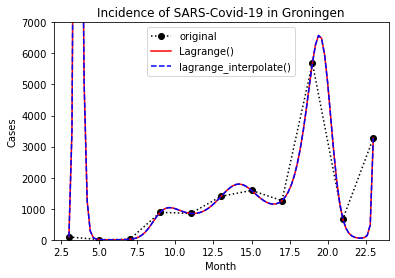

In [89]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])


x = np.linspace(3.0, 23.0, 101)

f = lagrange(months, np.log(cases))
lag_log = f(x)

vander_y = vander_interpolate(months, np.log(cases), x)


plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, np.exp(lag_log), '-r', label='Lagrange()')
plt.plot(x, np.exp(vander_y), '--b', label='lagrange_interpolate()')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

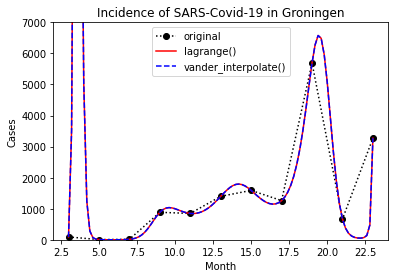

### Exercise 13

The [Factorial numbers](https://en.wikipedia.org/wiki/Factorial) $n!$ can be defined as the product of consecutive integers.

$$
n! = \prod_{k=1}^n k = 1 \cdot 2 \cdot 3 \ldots \cdot n
$$

This leads to the following [sequence](http://oeis.org/A000142).

| $n$    | 0   | 1   | 2   | 3   | 4   | 5   | 6   | ... |
| ------ | --- | --- | --- | --- | --- | --- | --- | --- |
| $n!$ | 1   | 1   | 2   | 6   | 24  | 120 | 720 | ... |

However, this definition only works for integer values of $n$.

Fit a polynomial to this sequence and interpolate the value for $\left( \frac{1}{2} \right) !$. How well does your answer agree with the theoretical value of $\left( \frac{1}{2} \right) ! = \frac{\sqrt{\pi}}{2} \approx 0.886$?

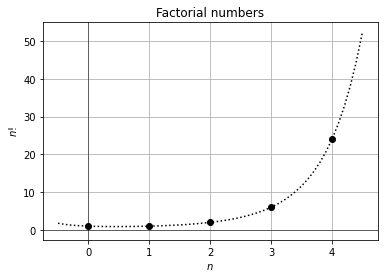

Figure 10: Factorial numbers


In [30]:
figure(10)

In [98]:
def factorial(n):
    total = 1
    for k in range(1, n+1):
        total *= k
        
    return total

from scipy.special import gamma

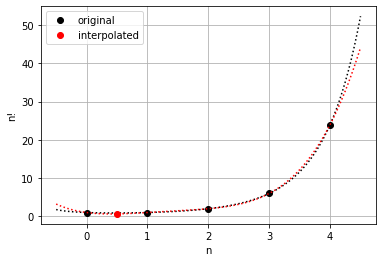

In [103]:
xi = [0, 1, 2, 3, 4]
yi = [factorial(n) for n in xi]

x = np.linspace(-0.5, 4.5, 101)

f = lagrange(xi, yi)
y = f(x)

x_half = 1/2
y_half = f(x_half)


plt.plot(xi, yi, 'o', color='black', label='original')
plt.plot(x, gamma(x + 1.0), ':k')

plt.plot(x, y, ':r')
plt.plot(x_half, y_half, 'o', color='red', label='interpolated')

plt.legend()
plt.grid()
plt.xlabel('n')
plt.ylabel('n!')

plt.show()

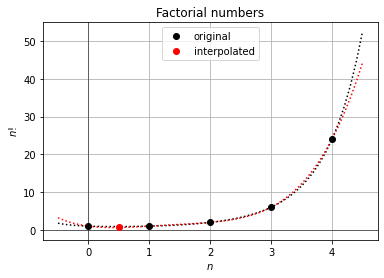

### <a id="/16">Lesson 1 - Polynomial interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 1A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/8">Part 1B</a><br />Lagrange interpolation</span>

* <span style="color:#336699"><a href="#/12">Part 1C</a><br />Vandermonde matrix interpolation</span>

* <u>Part 1D</u><br />*Rational interpolation*

### Rational interpolation

Sometimes, interpolation by means of a [rational function](https://en.wikipedia.org/wiki/Polynomial_and_rational_function_modeling) is appropriate. A rational function is the quotient of two polynomials.

$$
y(x) = \frac{a'_p \cdot x^p + \ldots + a'_1 \cdot x + a'_0}{b'_q \cdot x^q + \ldots + b'_1 \cdot x + b'_0}
$$

The ratio can be scaled by dividing the numerator and denominator by $b'_0$ to obtain a more common form.

$$
y(x) = \frac{a_p \cdot x^p + \ldots + a_1 \cdot x + a_0}{b_q \cdot x^q + \ldots + b_1 \cdot x + 1}
$$

This function has $n = p+q+1$ unknown coefficients.

For a pair of values $(x_i, y_i)$ that satisfies this rational form, we can write

$$
\left( a_p \cdot x_i^p + \ldots + a_1 \cdot x_i + a_0 \right) - \left( b_q \cdot x_i^q y_i + \ldots + b_1 \cdot x_i y_i \right) = y_i
$$

If we have a set of $n$ data points, these equations can again be written in matrix form $\boldsymbol{y} = \boldsymbol{X} \left[ \begin{array}{c} \boldsymbol{a} \\ \boldsymbol{b} \end{array} \right]$ as

$$
\left[\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}\right]=\left[\begin{array}{ccccccc}
x_1^p & \cdots & x_1 & 1 & -x_1^q y_1 & \cdots & -x_1 y_1\\
x_2^p & \cdots & x_2 & 1 & -x_2^q y_2 & \cdots & -x_2 y_2\\
\vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots\\
x_n^p & \cdots & x_n & 1 & -x_n^q y_n & \cdots & -x_n y_n
\end{array}\right]\left[\begin{array}{c}
a_p\\
\vdots\\
a_{1}\\
a_{0}\\
b_q\\
\vdots\\
b_{1}
\end{array}\right]
$$

This allows us to solve for the coefficients through $\left[ \begin{array}{c} \boldsymbol{a} \\ \boldsymbol{b} \end{array} \right] = \boldsymbol{X}^{-1} \boldsymbol{y}$.

If $p$ is chosen equal to $n-1$ and $q=0$, then the denominator equals 1 and the rational function becomes a regular polynomial again. For other values of $p$ and $q$ (that still suffice $p+q+1 = n$) we obtain more general solutions. A popular choice is to use a *diagonal* rational function in which the degree of the numerator is equal to (or 1 less than) that of the denominator.

Rational functions are typically smoother and less oscillatory than polynomials and are not required to go to infinity for extreme values of $x$. However, they can introduce undesirable asymptotes in the fit.

Sometimes a solution is ill-defined. For instance, a rational function $y(x) = \frac{x+1}{x-1}$ is identical to $y(x) = \frac{(x+1)(x+1)}{(x-1)(x+1)} = \frac{x^2+2x+1}{x^2-1}$. So, if one form is a solution, then also the other is a solution. In such a degenerate case the matrix $\boldsymbol{X}$ turns out not to be invertible and the method fails.

### Example

If we fit a rational function $y(x) = \frac{a_1 x + a_0}{b_1 x + 1}$ through the points $(0,1)$, $(1,2)$, and $(2,-1)$, we obtain three equations that can be simplified to the following form.

$$
\begin{aligned}
a_0 &= 1
\\
a_1 + a_0 - 2 b_1 &= 2
\\
2 a_1 + a_0 + 2 b_1 &= -1
\end{aligned}
$$

This can be solved by elimination to find $a_0 = 1$, $a_1 = -\frac{1}{3}$, $b_1 = -\frac{2}{3}$. The rational function equals

$$
y(x) = \frac{-\frac{1}{3} x + 1}{-\frac{2}{3}x + 1} = \frac{x-3}{2x-3}
$$

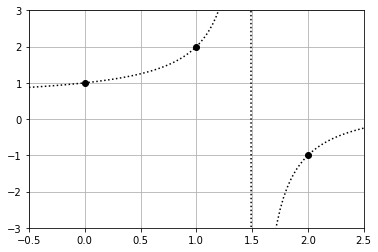

In [119]:
xi = np.array([0.0, 1.0, 2.0])
yi = np.array([1, 2, -1])

x = np.linspace(-0.5, 2.5, 101)
y = (-1/3 * x + 1) / (-2/3 * x +1)

plt.plot(xi, yi, 'o', color='black')
plt.plot(x, y, ':k')

plt.grid(True)
plt.xlim([-0.5, 2.5])
plt.ylim([-3, 3])

plt.show()

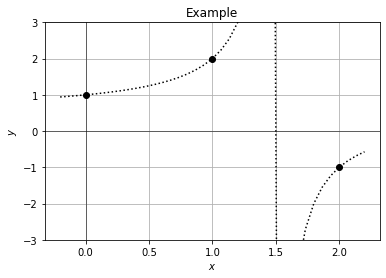

Figure 11: Example


In [32]:
figure(11)

### Exercise 14

Find the diagonal rational polynomial (i.e., here $p=1$ and $q=2$) that passes through the points $(-1, -2)$, $(0, 0)$, $(1, 2)$, and $(2, 2)$.

Do you prefer the polynomial fit or the rational fit for this example?

In [79]:
X = np.array([[-1, 1, 2, -2],
             [0, 1, 0, 0],
             [1, 1, -2, -2],
             [2, 1, -8, -4]])

y = np.array([-2, 0, 2, 2])

a = np.dot(np.linalg.inv(X), y)
a

array([3. , 0. , 0.5, 0. ])

### Exercise 15

Complete the below skeleton function `rational_interpolate()` that performs rational interpolation. The degrees of the numerator and/or denominator polynomials are provided as optional parameters `p` and `q` (by default, a diagonal rational function will be used).

```python
def rational_interpolate(xi, yi, x, *, p=None, q=None):
    """y = rational_interpolate(xi, yi, x, *, p=None, q=None).
    Rational interpolation method that fits a rational
    function of polynomial degrees p and q through n data
    points {xi,yi}, evaluated at arguments x. If neither p
    nor q are provided, a diagonal rational function is used.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    p      = polynomial degree numerator
    q      = polynomial degree denominator
    """
    if p is None:
        if q is None:
            q = yi.size // 2
        p = yi.size - q - 1
    elif q is None:
        q = yi.size - p - 1
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if yi.size != p + q + 1:
        raise ValueError('number of data points must equal p+q+1')
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [99]:
def rational_interpolate(xi, yi, x, *, p=None, q=None):
    """y = rational_interpolate(xi, yi, x, *, p=None, q=None).
    Rational interpolation method that fits a rational
    function of polynomial degrees p and q through n data
    points {xi,yi}, evaluated at arguments x. If neither p
    nor q are provided, a diagonal rational function is used.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    p      = polynomial degree numerator
    q      = polynomial degree denominator
    """
    if p is None:
        if q is None:
            q = yi.size // 2
        p = yi.size - q - 1
    elif q is None:
        q = yi.size - p - 1
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if yi.size != p + q + 1:
        raise ValueError('number of data points must equal p+q+1')
        
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    n = p + q + 1
    X = np.zeros((n, n))

    # index 0-based, all columns set to 1
    middle = p
    
    # create p-degree values
    p_vals = []
    for val in xi:
        temp = []
        for degree in range(p, 0, -1):
            p_val = val**degree
            temp.append(p_val)

        p_vals.append(temp)

    p_vals = np.array(p_vals)
    
    # create q-degree values
    q_vals = []
    for _x, _y in zip(xi, yi):
        temp = []
        for degree in range(q, 0, -1):
            q_val = -1 * (_x**degree * _y)
            temp.append(q_val)

        q_vals.append(temp)

    q_vals = np.array(q_vals)

    X[:, middle] = 1
    X[:, :p] = p_vals
    X[:, middle+1:] = q_vals
    
    coef = np.dot(np.linalg.inv(X), yi)
        
    a = coef[:p]
    mid = coef[p]
    b = coef[p+1:]

    p_vander = np.vander(x, p+1)[:, :-1]
    q_vander = np.vander(x, q+1)[:, :-1]

    y = ((a * p_vander).sum(axis=1) + mid) / ((b * q_vander).sum(axis=1) + 1)    
    return y

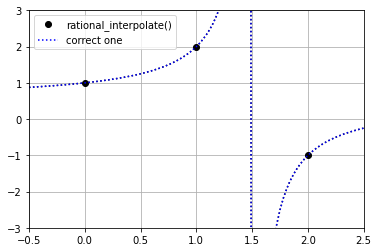

In [102]:
xi = np.array([0.0, 1.0, 2.0])
yi = np.array([1, 2, -1])

x = np.linspace(-0.5, 2.5, 101)
y = rational_interpolate(xi, yi, x, p=1, q=1)
y_correct = (-1/3 * x + 1) / (-2/3 * x +1)


plt.plot(xi, yi, 'o', color='black', label='rational_interpolate()')
plt.plot(x, y, ':k')
plt.plot(x, y_correct, ':', color='blue', label='correct one')

plt.grid(True)
plt.xlim([-0.5, 2.5])
plt.ylim([-3, 3])
plt.legend()
plt.show()

### Exercise 16

Compare the output of your own function `rational_interpolate()` to that of `scipy`'s `lagrange()` function for the data from exercise 1. Try different combinations of $p$ and $q$.

Out of all types of interpolation that you have tried, which works best, in your opinion?

In [64]:
from scipy.interpolate import lagrange

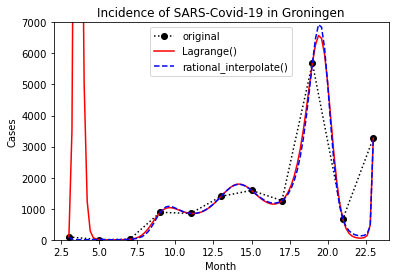

In [101]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])


x = np.linspace(3.0, 23.0, 101)

f = lagrange(months, np.log(cases))
y_log = f(x)

y_rat = rational_interpolate(months, np.log(cases), x, p=1, q=9)


plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, np.exp(y_log), '-r', label='Lagrange()')
plt.plot(x, np.exp(y_rat), '--b', label='rational_interpolate()')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

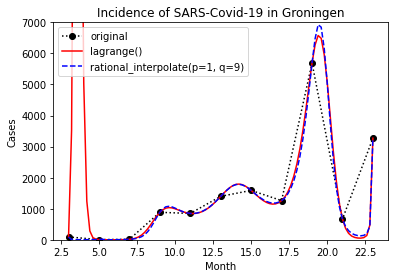

### Exercise 17

The [Catalan numbers](https://en.wikipedia.org/wiki/Catalan_number) $C(n)$ can be defined using the recurrence relation

$$
C(n+1) = \sum_{k=0}^n C(k)C(n-k)
$$

and starting value $C(0)=1$.

This leads to the following [sequence](http://oeis.org/A000045).

| $n$    | 0   | 1   | 2   | 3   | 4   | 5   | 6   | ... |
| ------ | --- | --- | --- | --- | --- | --- | --- | --- |
| $C(n)$ | 1   | 1   | 2   | 5   | 14  | 42  | 132 | ... |

However, this definition only works for integer values of $n$.

Fit a polynomial to this sequence and interpolate the value for $C(\frac{1}{2})$. How well does your answer agree with the theoretical value of $C(\frac{1}{2}) = \frac{8}{3\pi} \approx 0.849$?

In [112]:
def C(n):
    if n == 0 or n == 1:
        return 1
    
    total = 1
    for k in range(2, n+1):
        total *= (n+k)/k
        
    return total

C(6)

132.0

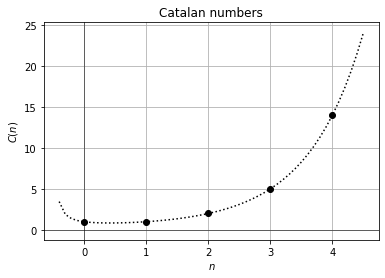

Figure 12: Catalan numbers


In [35]:
figure(12)

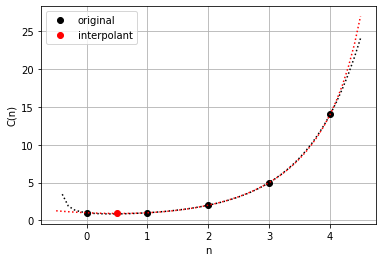

In [120]:
from scipy.special import gamma

xi = np.array([0, 1, 2, 3, 4])
yi = np.array([1, 1, 2, 5, 14])

x = np.linspace(-0.5, 4.5, 51)
y = rational_interpolate(xi, yi, x)

x_half = np.array([1/2])
y_half = rational_interpolate(xi, yi, x_half)

plt.plot(xi, yi, 'ok', label='original')
plt.plot(x, gamma(2.0 * x + 1.0) / (gamma(x + 1.0) * gamma(x + 2.0)), ':k')

plt.plot(x, y, ':r')
plt.plot(x_half, y_half, 'or', label="interpolant")

plt.grid(True)
plt.legend()

plt.xlabel('n')
plt.ylabel('C(n)')

plt.show()

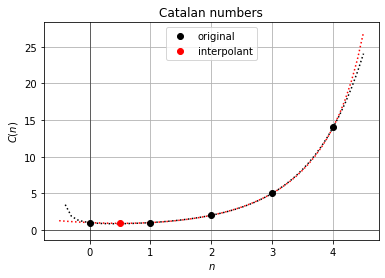

### End of lesson 1

Congratulations for finishing this lesson!

* Run your full notebook from scratch to ensure it works correctly (i.e., `Kernel` > `Restart & Run All`).

* Save your working version (i.e., `File` > `Save and Checkpoint`).

* Submit your completed notebook on [BlackBoard](https://blackboard.hanze.nl).

If handed in on time, you will be provided with feedback on your implementation of the `rational_interpolate()` function in **Part 1D**.

***